# Player Development & Aging Curve Analysis

This notebook implements the workflow described in `player_development_analysis_aging_curve.md`, covering:

1. Building aging curves for performance and valuation by position and age.
2. Computing per-player development metrics (expected vs actual value/performance).
3. Generating an `aging_score` and `development_tier` that can be merged into the recommendation pipeline.
4. Showing how to refresh the analysis when new raw data arrives.

## 1. Imports & Global Config
All imports remain in a single cell so the notebook is easy to rerun when dependencies change.

In [1]:

# Core analysis stack
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configure aesthetics for visual checks
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.figsize": (12, 6)})

# Constants used across functions
DATA_DIR = Path("../data")
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(exist_ok=True)
MILLION = 1_000_000


## 2. Helper Functions
Functions encapsulate key steps (loading data, computing age, smoothing) so the same logic can be reused when new data arrives.

In [2]:

def load_raw_data(data_dir: Path) -> dict:
    """Load all CSVs required for the development analysis."""
    files = {
        "players": "players.csv",
        "player_valuations": "player_valuations.csv",
        "appearances": "appearances.csv",
        "competitions": "competitions.csv",
        "games": "games.csv",
    }
    dfs = {}
    for key, fname in files.items():
        path = data_dir / fname
        dfs[key] = pd.read_csv(path)
        print(f"Loaded {key} with {dfs[key].shape[0]:,} rows")
    return dfs


def compute_age(birth_date: pd.Series, reference_date: pd.Series) -> pd.Series:
    """Return age in years (float) for each reference date."""

    return (reference_date - birth_date).dt.days / 365.25


def agg_by_age_sub_position(df: pd.DataFrame, value_col: str, smooth: bool = False) -> pd.DataFrame:
    """Aggregate a column by age & position; optionally apply rolling smoothing."""

    grouped = (
        df.groupby(["sub_position", "age"])[value_col]
        .median()
        .reset_index()
        .sort_values(["sub_position", "age"])
    )
    if smooth:
        grouped[value_col] = grouped.groupby("sub_position")[value_col].transform(lambda s: s.rolling(3, center=True, min_periods=1).mean())
    grouped.rename(columns={value_col: f"expected_{value_col}"}, inplace=True)
    return grouped


def zscore(series: pd.Series) -> pd.Series:
    """Return the z-score with guard against zero std."""

    std = series.std(ddof=0)
    if std == 0:
        return pd.Series(0, index=series.index)
    return (series - series.mean()) / std


## 3. Load and Preprocess Data
Convert dates to datetime and compute age fields shared by valuation and performance datasets.

In [ ]:

dfs = load_raw_data(DATA_DIR)
players = dfs["players"].copy()
valuations = dfs["player_valuations"].copy()
appearances = dfs["appearances"].copy()

players["date_of_birth"] = pd.to_datetime(players["date_of_birth"], errors="coerce")
valuations["date"] = pd.to_datetime(valuations["date"], errors="coerce")
appearances["date"] = pd.to_datetime(appearances["date"], errors="coerce")

# Merge player attributes (position, date_of_birth) into valuations
valuations = valuations.merge(players[["player_id", "sub_position", "date_of_birth"]], on="player_id", how="inner")
valuations.dropna(subset=["date", "date_of_birth"], inplace=True)
valuations["age_exact"] = compute_age(valuations["date_of_birth"], valuations["date"])
# Round age to nearest quarter-year (0.25 years)
valuations["age"] = np.round(valuations["age_exact"] * 4) / 4
valuations = valuations[(valuations["age"] >= 16) & (valuations["age"] <= 40)]

# Merge player attributes into appearances and process ages
appearances = appearances.merge(players[["player_id", "sub_position", "date_of_birth"]], on="player_id", how="inner")
appearances.dropna(subset=["date", "date_of_birth"], inplace=True)
appearances["age_exact"] = compute_age(appearances["date_of_birth"], appearances["date"])
# Round age to nearest quarter-year (0.25 years)
appearances["age"] = np.round(appearances["age_exact"] * 4) / 4
appearances = appearances[(appearances["age"] >= 16) & (appearances["age"] <= 40)]
appearances["minutes_per_appearance"] = appearances["minutes_played"].clip(lower=1)



Loaded players with 32,601 rows
Loaded player_valuations with 496,606 rows
Loaded appearances with 1,706,806 rows
Loaded competitions with 44 rows
Loaded games with 74,026 rows


## 4. Build Aging Curves
We compute valuation and performance curves by age and position.

In [ ]:
valuations["value_million"] = valuations["market_value_in_eur"] / MILLION

# 方法 1：過濾掉樣本數不足的年齡組和 38 歲以上的球員（避免極端值）
# 先排除 38 歲以上的球員
valuations_age_filtered = valuations[valuations["age"] < 38]
# 再過濾掉樣本數不足的年齡組
valuation_counts = valuations_age_filtered.groupby(["sub_position", "age"]).size().reset_index(name="count")
valid_age_groups = valuation_counts[valuation_counts["count"] >= 10][["sub_position", "age"]]
valuations_filtered = valuations_age_filtered.merge(valid_age_groups, on=["sub_position", "age"], how="inner")

valuation_curve = agg_by_age_sub_position(valuations_filtered, "value_million", smooth=True)

# 先排除 38 歲以上的球員
appearances_age_filtered = appearances[appearances["age"] < 38]

# Correct calculation of ga_per_90: first aggregate by position and age, then calculate per 90
perf_agg = appearances_age_filtered.groupby(["sub_position", "age"]).agg({
    "goals": "sum",
    "assists": "sum",
    "minutes_per_appearance": "sum",
    "player_id": "count"  # 計算樣本數（比賽場次）
}).reset_index()
perf_agg.rename(columns={"player_id": "sample_count"}, inplace=True)

# 方法 1：過濾掉樣本數不足的年齡組（至少 20 場比賽記錄）
perf_agg_filtered = perf_agg[perf_agg["sample_count"] >= 20].copy()

# Calculate total goals + assists per 90 minutes
perf_agg_filtered["ga_per_90"] = ((perf_agg_filtered["goals"] + perf_agg_filtered["assists"]) / perf_agg_filtered["minutes_per_appearance"]) * 90

# Calculate AVERAGE minutes per appearance (NOT total)
# minutes_per_appearance is the TOTAL minutes, sample_count is the number of appearances
# So we divide to get the AVERAGE minutes per appearance
perf_agg_filtered["minutes_per_90"] = perf_agg_filtered["minutes_per_appearance"] / perf_agg_filtered["sample_count"]

# 方法 2：設定合理的上下限（避免極端值）
# 使用 5th 和 95th percentile 作為邊界
ga_5th = perf_agg_filtered["ga_per_90"].quantile(0.05)
ga_95th = perf_agg_filtered["ga_per_90"].quantile(0.95)
perf_agg_filtered["ga_per_90"] = perf_agg_filtered["ga_per_90"].clip(lower=ga_5th, upper=ga_95th)

# 方法 3：應用更強的平滑處理（窗口增大到 5）
perf_agg_filtered = perf_agg_filtered.sort_values(["sub_position", "age"])
perf_agg_filtered["ga_per_90"] = perf_agg_filtered.groupby("sub_position")["ga_per_90"].transform(
    lambda s: s.rolling(5, center=True, min_periods=2).mean()
)
perf_agg_filtered["minutes_per_90"] = perf_agg_filtered.groupby("sub_position")["minutes_per_90"].transform(
    lambda s: s.rolling(5, center=True, min_periods=2).mean()
)

# Rename and select needed columns
perf_ga_curve = perf_agg_filtered[["sub_position", "age", "ga_per_90"]].rename(
    columns={"ga_per_90": "expected_ga_per_90"}
)
perf_min_curve = perf_agg_filtered[["sub_position", "age", "minutes_per_90"]].rename(
    columns={"minutes_per_90": "expected_minutes_per_90"}
)

curves = valuation_curve.merge(perf_ga_curve, on=["sub_position", "age"], how="outer")
curves = curves.merge(perf_min_curve, on=["sub_position", "age"], how="outer")
curves.sort_values(["sub_position", "age"], inplace=True)

print(f"✅ Valuation curve: {len(valuation_curve)} age-position combinations (filtered from {len(valuation_counts)})")
print(f"✅ Performance curve: {len(perf_ga_curve)} age-position combinations (filtered from {len(perf_agg)})")
print(f"✅ GA per 90 range: {perf_ga_curve['expected_ga_per_90'].min():.3f} - {perf_ga_curve['expected_ga_per_90'].max():.3f}")
print(f"✅ Market value range: {valuation_curve['expected_value_million'].min():.3f} - {valuation_curve['expected_value_million'].max():.3f}M€")

curves.tail(30)


✅ Valuation curve: 1105 age-position combinations (filtered from 1141)
✅ Performance curve: 1075 age-position combinations (filtered from 1132)
✅ GA per 90 range: 0.003 - 0.576
✅ Market value range: 0.050 - 1.517M€


,sub_position,age,expected_value_million,expected_ga_per_90,expected_minutes_per_90
1088,Second Striker,30.50,0.850000,0.567220,63.267426
1089,Second Striker,30.75,0.900000,0.575831,64.145961
1090,Second Striker,31.00,0.766667,0.575831,65.854524
1091,Second Striker,31.25,0.866667,0.575831,66.330812
1092,Second Striker,31.50,0.791667,0.575831,66.467403
1093,Second Striker,31.75,0.808333,0.571799,66.259153
1094,Second Striker,32.00,0.641667,0.551731,65.610426
1095,Second Striker,32.25,0.683333,0.551731,64.272932
1096,Second Striker,32.50,0.683333,0.551625,63.421469
1097,Second Striker,32.75,0.783333,0.549729,61.593190


In [50]:
# Analyze the number and distribution of players aged 38 and above
print("===== Analysis of Players Aged 38 and Above =====")

# 1. Calculate the total number of players aged 38 and above
old_players = valuations[valuations["age"] >= 38]
old_players_count = old_players["player_id"].nunique()
print(f"Total number of players aged 38 and above: {old_players_count}")

# 2. Calculate player count for each age
age_counts = old_players.groupby("age")["player_id"].nunique().reset_index()
age_counts.columns = ["Age", "Player Count"]
display(age_counts)

# 3. Calculate sample count for each position-age group
position_age_counts = old_players.groupby(["sub_position", "age"]).size().reset_index(name="Sample Count")
position_age_counts = position_age_counts.sort_values(["sub_position", "age"])
display(position_age_counts)

# 4. View goals and assists for players aged 38 and above
old_appearances = appearances[appearances["age"] >= 38]
old_appearances_count = old_appearances["player_id"].nunique()
print(f"Number of players aged 38 and above with appearance records: {old_appearances_count}")

# 5. Calculate match count for each position-age group
position_age_matches = old_appearances.groupby(["sub_position", "age"]).size().reset_index(name="Match Count")
position_age_matches = position_age_matches.sort_values(["Match Count"], ascending=False).head(10)
display(position_age_matches)

# 6. Calculate ga_per_90 statistics for players aged 38 and above
old_perf = appearances[appearances["age"] >= 38].groupby(["sub_position", "age"]).agg({
    "goals": "sum",
    "assists": "sum",
    "minutes_per_appearance": "sum",
    "player_id": "count"
}).reset_index()

old_perf["ga_per_90"] = ((old_perf["goals"] + old_perf["assists"]) / old_perf["minutes_per_appearance"]) * 90
old_perf = old_perf.sort_values("ga_per_90", ascending=False).head(10)
old_perf.columns = ["Position", "Age", "Total Goals", "Total Assists", "Total Minutes Played", "Match Count", "GA per 90"]
display(old_perf)

print("===== Analysis Conclusion =====")
print("The sample size for players aged 38 and above is very small, making it prone to extreme values. It is recommended not to include these in the analysis.")


===== Analysis of Players Aged 38 and Above =====
Total number of players aged 38 and above: 661


,Age,Player Count
0,38.00,339
1,38.25,299
2,38.50,241
3,38.75,215
4,39.00,173
5,39.25,157
6,39.50,128
7,39.75,92
8,40.00,94


,sub_position,age,Sample Count
0,Attacking Midfield,38.00,17
1,Attacking Midfield,38.25,12
2,Attacking Midfield,38.50,11
3,Attacking Midfield,38.75,8
4,Attacking Midfield,39.00,8
...,...,...,...
98,Second Striker,38.50,2
99,Second Striker,38.75,2
100,Second Striker,39.00,1
101,Second Striker,39.25,1


Number of players aged 38 and above with appearance records: 256


,sub_position,age,Match Count
44,Goalkeeper,38.00,433
46,Goalkeeper,38.50,325
48,Goalkeeper,39.00,272
45,Goalkeeper,38.25,260
47,Goalkeeper,38.75,257
17,Centre-Back,38.00,225
18,Centre-Back,38.25,194
26,Centre-Forward,38.00,159
8,Central Midfield,38.00,148
19,Centre-Back,38.50,139


,Position,Age,Total Goals,Total Assists,Total Minutes Played,Match Count,GA per 90
98,Second Striker,39.50,4,2,166,9,3.253012
100,Second Striker,40.00,2,7,405,9,2.000000
97,Second Striker,39.25,0,1,51,2,1.764706
56,Left Midfield,39.50,0,3,251,6,1.075697
77,Right Winger,38.75,1,0,85,2,1.058824
80,Right Winger,39.50,1,3,373,10,0.965147
34,Centre-Forward,40.00,9,7,1744,43,0.825688
95,Second Striker,38.75,1,1,225,3,0.800000
92,Second Striker,38.00,3,4,789,12,0.798479
30,Centre-Forward,39.00,27,9,4850,91,0.668041


===== Analysis Conclusion =====
The sample size for players aged 38 and above is very small, making it prone to extreme values. It is recommended not to include these in the analysis.


## 5. Compute Player-Level Deviations

In [51]:

# Step 1: Get latest valuation for each player
latest_values = valuations.sort_values("date").drop_duplicates("player_id", keep="last")

# Step 2: Correctly calculate each player's actual ga_per_90 (goals + assists per 90 minutes)
# First, sum each player's total goals, assists, and minutes played, then calculate per 90.
player_performance = appearances.groupby("player_id").agg({
    "goals": "sum",
    "assists": "sum",
    "minutes_per_appearance": "sum",
    "game_id": "count"  # Count number of appearances
}).reset_index()
player_performance.rename(columns={"game_id": "appearance_count"}, inplace=True)

# Calculate each player's actual ga_per_90 and average minutes played
player_performance["ga_per_90"] = (
    (player_performance["goals"] + player_performance["assists"]) / 
    player_performance["minutes_per_appearance"]
) * 90

# Calculate AVERAGE minutes per appearance (NOT total)
# Divide total minutes by number of appearances to get average
player_performance["minutes_per_90"] = player_performance["minutes_per_appearance"] / player_performance["appearance_count"]

# Keep only the necessary columns
player_performance = player_performance[["player_id", "ga_per_90", "minutes_per_90"]]

# Step 3: Merge performance data with latest valuations
latest_values = latest_values.merge(player_performance, on="player_id", how="left")

# Step 4: Merge with aging curves to get expected values
latest_values = latest_values.merge(curves, on=["sub_position", "age"], how="left", suffixes=("", "_expected"))

# Step 5: Calculate deviations from curves
latest_values["valuation_above_curve"] = latest_values["value_million"] - latest_values["expected_value_million"]
latest_values["performance_above_curve"] = latest_values["ga_per_90"] - latest_values["expected_ga_per_90"]
latest_values["minutes_above_curve"] = latest_values["minutes_per_90"] - latest_values["expected_minutes_per_90"]

# Step 6: Calculate z-scores
latest_values["valuation_z"] = zscore(latest_values["valuation_above_curve"].fillna(0))
latest_values["performance_z"] = zscore(latest_values["performance_above_curve"].fillna(0))
latest_values["minutes_z"] = zscore(latest_values["minutes_above_curve"].fillna(0))

# Step 7: Calculate composite aging score
latest_values["aging_score"] = (
    0.5 * latest_values["valuation_z"]
    + 0.3 * latest_values["performance_z"]
    + 0.2 * latest_values["minutes_z"]
)

# Step 8: Assign development tier
latest_values["development_tier"] = pd.cut(
    latest_values["aging_score"],
    bins=[-np.inf, 0, 0.75, np.inf],
    labels=["declining", "normal", "aging well"],
)

# Display sample results
latest_values[[
    "player_id",
    "sub_position",
    "age",
    "value_million",
    "expected_value_million",
    "valuation_above_curve",
    "aging_score",
    "development_tier",
    "minutes_per_90",
    "expected_minutes_per_90",
]].head()


,player_id,sub_position,age,value_million,expected_value_million,valuation_above_curve,aging_score,development_tier,minutes_per_90,expected_minutes_per_90
0,16733,Goalkeeper,29.50,0.100,0.616667,-0.516667,-0.015138,declining,NaN,89.462767
1,73096,Left-Back,20.50,0.050,0.266667,-0.216667,-0.336652,declining,43.0,69.107829
2,4582,Goalkeeper,37.75,0.800,0.200000,0.600000,0.072315,normal,NaN,88.611910
3,36758,Goalkeeper,39.75,0.025,NaN,NaN,0.025325,normal,NaN,NaN
4,62553,Centre-Forward,19.50,0.200,0.250000,-0.050000,0.732093,normal,85.0,41.008290


## 6. Visualize Aging Curves

In [52]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 創建包含三個子圖的視覺化
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        "Median Market Value by Age & Sub Position (Smoothed)",
        "Goals + Assists per 90 minutes by Age & Sub Position (Smoothed)",
        "Playing Time (Minutes per 90) by Age & Sub Position (Smoothed)"
    ),
    vertical_spacing=0.12,
    specs=[[{"type": "scatter"}], [{"type": "scatter"}], [{"type": "scatter"}]]
)

# 獲取所有位置的唯一值
all_positions = set()
all_positions.update(valuation_curve["sub_position"].unique())
all_positions.update(perf_ga_curve["sub_position"].unique())
all_positions.update(perf_min_curve["sub_position"].unique())
all_positions = sorted(list(all_positions))

# 為每個位置分配顏色
colors = px.colors.qualitative.Plotly + px.colors.qualitative.Set3
color_map = dict(zip(all_positions, colors[:len(all_positions)]))

# 第一個圖：Market Value
for position in valuation_curve["sub_position"].unique():
    data = valuation_curve[valuation_curve["sub_position"] == position]
    fig.add_trace(
        go.Scatter(
            x=data["age"],
            y=data["expected_value_million"],
            name=position,
            mode="lines",
            line=dict(color=color_map[position]),
            legendgroup=position,
            showlegend=True
        ),
        row=1, col=1
    )

# 第二個圖：Goals + Assists per 90
for position in perf_ga_curve["sub_position"].unique():
    data = perf_ga_curve[perf_ga_curve["sub_position"] == position]
    fig.add_trace(
        go.Scatter(
            x=data["age"],
            y=data["expected_ga_per_90"],
            name=position,
            mode="lines",
            line=dict(color=color_map[position]),
            legendgroup=position,
            showlegend=False
        ),
        row=2, col=1
    )

# 第三個圖：Minutes per 90
for position in perf_min_curve["sub_position"].unique():
    data = perf_min_curve[perf_min_curve["sub_position"] == position]
    fig.add_trace(
        go.Scatter(
            x=data["age"],
            y=data["expected_minutes_per_90"],
            name=position,
            mode="lines",
            line=dict(color=color_map[position]),
            legendgroup=position,
            showlegend=False
        ),
        row=3, col=1
    )

# 更新軸標籤
fig.update_xaxes(title_text="Age", row=3, col=1)
fig.update_yaxes(title_text="Market Value (million €)", row=1, col=1)
fig.update_yaxes(title_text="Goals + Assists per 90", row=2, col=1)
fig.update_yaxes(title_text="Minutes per 90", row=3, col=1)

# 更新整體布局
fig.update_layout(
    height=1200,
    title_text="Aging Curves: Market Value, Performance, and Playing Time by Position",
    legend_title_text="Sub Position",
    showlegend=True,
    hovermode="x unified"
)

fig.show()


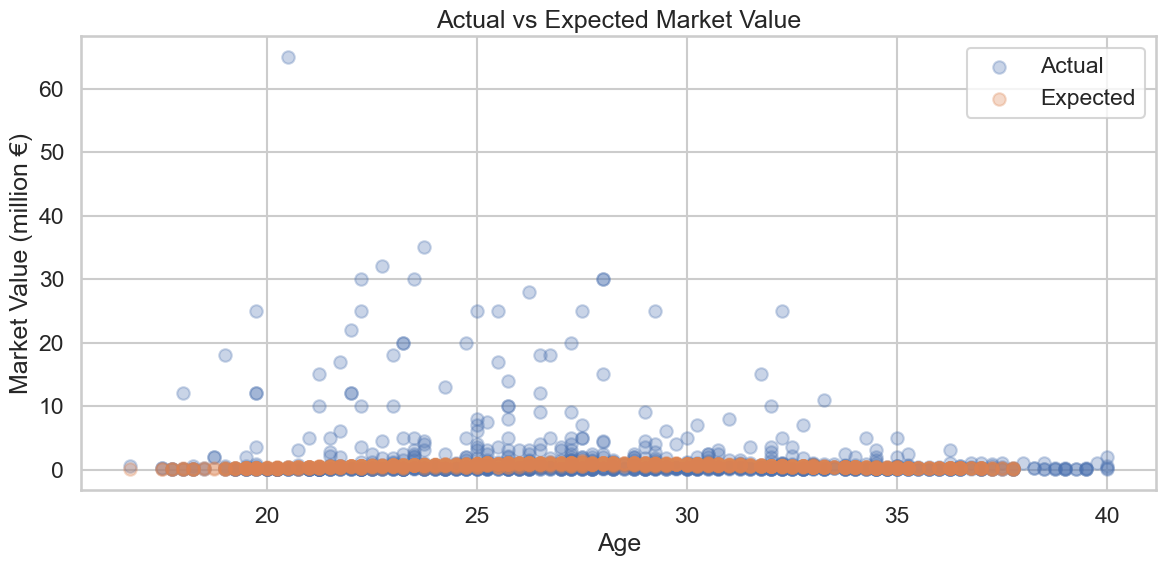

In [53]:

sample = latest_values.sample(1000, random_state=42) if len(latest_values) > 1000 else latest_values
plt.figure()
plt.scatter(sample["age"], sample["value_million"], alpha=0.3, label="Actual")
plt.scatter(sample["age"], sample["expected_value_million"], alpha=0.3, label="Expected")
plt.title("Actual vs Expected Market Value")
plt.xlabel("Age")
plt.ylabel("Market Value (million €)")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Persist Development Outputs

In [54]:

output_cols = [
    "player_id",
    "age",
    "sub_position",
    "value_million",
    "expected_value_million",
    "valuation_above_curve",
    "ga_per_90",
    "expected_ga_per_90",
    "performance_above_curve",
    "minutes_per_90",
    "expected_minutes_per_90",
    "minutes_above_curve",
    "aging_score",
    "development_tier",
]

development_outputs = latest_values[output_cols].copy()
output_path = PROCESSED_DIR / "development_outputs.parquet"
development_outputs.to_parquet(output_path, index=False)
print(f"Saved development dataset to {output_path}")


Saved development dataset to ../data/processed/development_outputs.parquet


## 8. Refreshing with New Data
To rerun with new CSVs, point `DATA_DIR` to the folder containing them and rerun all cells. Each helper function is parameterized by `data_dir`, so outputs regenerate without additional code changes.